In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tensorflow as tf
import math

In [48]:
# %load nn17_ex3_main.py
#!/usr/bin/env python3

# Import Data

# plt.close('all')  # if you like

# load dataset

with open('isolet_crop_train.pkl', 'rb') as f:
    train_data = pkl.load(f)

with open('isolet_crop_test.pkl', 'rb') as f:
    test_data = pkl.load(f)

X_train, y_train = train_data
X_test, y_test = test_data

y_train = y_train - 1 
y_test = y_test - 1  

# normalize the data and check the results

# ...

#print(X_train.mean(axis=0))
#print(X_train.var(axis=0))

# split the data sets, etc.

# ...

In [49]:
# Get training Data statistics

# Number of Training examples
n_train = len(X_train)
# Number of Testing examples
n_test = len(X_test)
# Number of Training features
n_TrainFeatures = len(X_train[0])
# Number of Testing features (should be equal to that of training)
n_TestFeatures = len (X_test[0])
# Number of Training classes
n_TrainClasses =  len(np.unique(y_train))
# Number of Testing Classes (should be equal to that of training)
n_TestClasses = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("....")
print("Number of Training features =", n_TrainFeatures)
print("Number of Testing features =", n_TestFeatures)
print("....")
print("Number of Training Classes =", n_TrainClasses)
print("Number of Testing Classes =", n_TestClasses)

Number of training examples = 6238
Number of testing examples = 1559
....
Number of Training features = 300
Number of Testing features = 300
....
Number of Training Classes = 26
Number of Testing Classes = 26


##  a) Make yourself familiar with the dataset. Normalize each feature to zero mean and unitvariance.

In [50]:
#X_train, y_train = train_data
#X_test, y_test = test_data

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Training data normalization
X_train = (X_train - X_mean) / X_std

# Testing data normalization
X_test = (X_test - X_mean) / X_std

# Split Data

In [51]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

from sklearn.model_selection import train_test_split
# First split in 70% -- 30%
X_train2, X_temp, y_train2, y_temp  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#Split the 30% into half to get 15% -- 15% (from X_train)for validation and early stop
X_validation, X_stop, y_validation, y_stop = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

n_input = len(X_train2)

In [52]:
print(X_train.shape)
print(y_train.shape)
print(X_train2.shape)
print(y_train2.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_stop.shape)
print(y_stop.shape)

(6238, 300)
(6238,)
(4366, 300)
(4366,)
(936, 300)
(936,)
(936, 300)
(936,)


## one-out-of-K coding

tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 300))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y, 26)


# Network

In [53]:

def Train_Classifier(x, Layers = [20,26],activation = tf.sigmoid):
    
    #print("In Traffic Sign Classifier.......................................................................... \n")
   
    #M = x.shape[1] #300
    M = x.get_shape().as_list()[1]
    M = float(M)
    C = Layers[-1] #26
    n_layers = len(Layers)
    Layers = np.insert(Layers,0,M)
    W = []
    b = []
    a = []
    z = []
    min_d = 1./math.sqrt(300)
    for i in range(n_layers):
        W.append(tf.Variable(tf.random_uniform([Layers[i], Layers[i+1]],-min_d,min_d),name='weights_{}'.format(i)))
        b.append(tf.Variable(tf.zeros(Layers[i+1]),name='bias_{}'.format(i)))
        if i == 0:
            a.append(tf.add(tf.matmul(x,W[i]),b[i]))
        else:
            a.append(tf.add(tf.matmul(z[i-1],W[i]),b[i]))
        z.append(activation(a[i]))
    logits =  a[-1]
    
    return logits

In [54]:
def build_combinations():
    Logits = []
    #optimizers = []
    #rates = []
    C = n_TrainClasses

    Algo = {0:tf.sigmoid, 1:tf.tanh,2:tf.nn.relu}
    Optzr = {0: tf.train.GradientDescentOptimizer, 1: tf.train.RMSPropOptimizer,
             2: tf.train.AdamOptimizer}
    Rate = {0: [0.05] , 1:[0.1], 2:[0.01]}

    Neur = [20]
    #Cross_entropys = []
    for hidden_layers in range(1):
        for p in range(len(Neur)):
            for i in range(len(Algo)):
                for j in range(len(Optzr)):
                    for k in range(len(Rate[j])):
                        # Model is determined
                        for runs in range(10):
                            neurons = Neur[p]
                            arch = np.ones(hidden_layers+1) * neurons
                            arch = np.append(arch,C).astype(int)
                            #train(Train_Classifier(x,arch, Algo[i]),Optzr[j],Rate[k])
                            # Logits.append(Train_Classifier(x,[20,C], Algo[i])) # TODO
                        
    return Logits

In [55]:
def evaluate(X_data, y_data,accuracy_operation):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
    

In [56]:
def network(logits,opt,rate):
    #sess.run(tf.global_variables_initializer())
    #tf.reset_default_graph()
    
    #x = tf.placeholder(tf.float32, (None, 300))
    #y = tf.placeholder(tf.int32,(None))
    #one_hot_y = tf.one_hot(y, 26)
    
    #print(logits)
    rate = 0.1 # learning rate

    EPOCHS = 100
    BATCH_SIZE = 40
    #logits = Logits[0]
    #logits = Train_Classifier(x,[100,26],activation = 1)#,n_TrainFeatures, n_TrainClasses)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)

    #optimizer = tf.train.RMSPropOptimizer(0.002)
    #optimizer = tf.train.AdamOptimizer(0.005)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)
    optimizer = opt(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)
    
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #saver =tf.train.Saver()
    #print("Initialized")
    return training_operation,accuracy_operation

In [57]:
def train(logits, opt, rate,stop_on_convergence = True,ret = 'model'):
    save_file = './modelTest1.ckpt'
    
    
    #np.array(train_acc_list)
    
    #with tf.Session() as sess:
    training_operation,accuracy_operation = network(logits,opt,rate)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train2)

    TempValidat_acc_list = []
    TempTrain_acc_list = []
    TempEarlyStopping_acc_list = []

    validat_acc_list = []
    train_acc_list = []
    earlyStoping_acc_list = []

    earlyStoppingMax = -1
    val_for_best_model = -1

    #logits = (Train_Classifier(x,[20,C], Algo[j]))
    #network(logits)
    for i in range(EPOCHS):
         
        X_train21, y_train21 = shuffle(X_train2,y_train2)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train21[offset:end], y_train21[offset:end]
            #logits = Logits[j]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            #print(logits)

        validation_accuracy = evaluate(X_validation, y_validation,accuracy_operation)
        training_accuracy = evaluate(X_train2, y_train2,accuracy_operation)
        earlyStoping_accuracy = evaluate(X_stop,y_stop,accuracy_operation)

        if earlyStoppingMax < earlyStoping_accuracy:
            earlyStoppingMax = earlyStoping_accuracy
            val_for_best_model = validation_accuracy
            #print('Best so far = {} on iteration {}'.format(earlyStoppingMax,i))
            #saver.save(sess,save_file)
            #print(sess.run(tempw))

        
        TempValidat_acc_list.append(validation_accuracy)
        TempTrain_acc_list.append(training_accuracy)
        TempEarlyStopping_acc_list.append(earlyStoping_accuracy)



        if i%STEP_SIZE == 0:
            validat_acc_list.append(np.mean(TempValidat_acc_list))
            TempValidat_acc_list = []

            train_acc_list.append(np.mean(TempTrain_acc_list))
            TempTrain_acc_list = []           

            earlyStoping_acc_list.append(np.mean(TempEarlyStopping_acc_list))
            TempEarlyStopping_acc_list = []  
            #print("EPOCH {} ...".format(i+1))
            #print("Validation Accuracy = {:.3f}".format(validat_acc_list[-1]))
            if stop_on_convergence and len(validat_acc_list) > 1:
                if validat_acc_list[-1] < validat_acc_list[-2] - 1e-3:
                    print("#############STOP################")
                    break
        ## end for
    #print(earlyStoppingMax)
    if ret == 'plots':
        return train_acc_list,validat_acc_list,earlyStoping_acc_list
    elif ret == 'error':
        return 1-val_for_best_model
    elif ret == 'model':
        return 0 # TODO
    #return earlyStoppingMax
    #Valid_acc_lists[j] = validat_acc_list
    #Train_acc_lists[j] = train_acc_list
    #EarlyStopping_acc_lists[j] = earlyStoping_acc_list
        





In [58]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 300))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y, 26)

In [59]:
EPOCHS = 300
BATCH_SIZE = 40
INDP_RUNS = 2
STEP_SIZE = 10

def try_comb(classifier,optimizer, rate):
    err = 0
    for i in range(INDP_RUNS):
        err += train(classifier,optimizer,rate)
    return err / INDP_RUNS

with tf.Session() as sess:
    result = try_comb(Train_Classifier(x) , tf.train.RMSPropOptimizer,0.005)
    print(result)

In [60]:
def try_comb(classifier,optimizer, rate):
    train_list, val_list, es_list = train(classifier,optimizer,rate,stop_on_convergence = False,ret = 'plots')
    train_list = np.array(train_list)
    val_list = np.array(val_list)
    es_list = np.array(es_list)
    for i in range(INDP_RUNS-1):
        tr, va, es = train(classifier,optimizer,rate,stop_on_convergence = False,ret = 'plots')
        train_list = train_list + np.array(tr)
        val_list =val_list + np.array(va)
        es_list = es_list + np.array(es)
    return np.divide(train_list,INDP_RUNS),np.divide(val_list,INDP_RUNS),np.divide(es_list,INDP_RUNS)

### Now we compare the rates for each optimizing algorithm and choose the best ones
#### The architecture is fixed for comparison which is one hidden layer with the same number of neurons and the number of epochs is fixed too

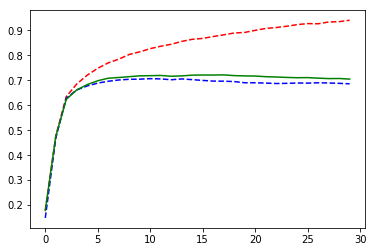

Accuracy of rate 0.01 = 0.6966880337932171, es = 0.7219551269442606


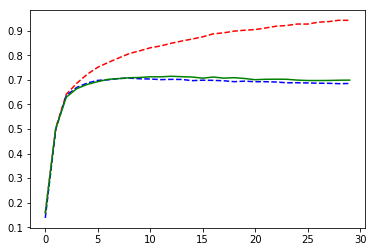

Accuracy of rate 0.05 = 0.7023504255164382, es = 0.7150106822833037


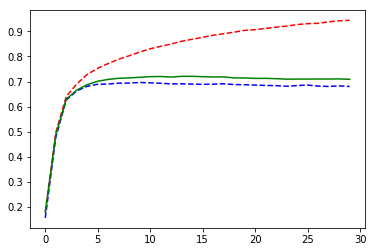

Accuracy of rate 0.1 = 0.6908119664360316, es = 0.7206730769230769


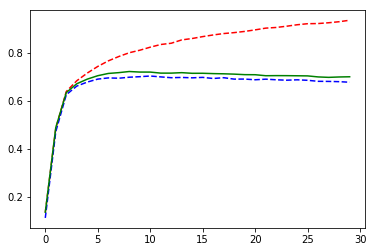

Accuracy of rate 0.5 = 0.6980235009621352, es = 0.7218482906747068


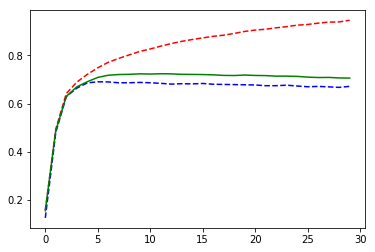

Accuracy of rate 1.0 = 0.6838141017489963, es = 0.7237179494566388


In [42]:
sgd_rates = np.array([0.01,0.05,0.1,0.5,1])
#x_axis = np.linspace(0,EPOCHS,10)
for rate in sgd_rates:
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.GradientDescentOptimizer,rate)
        plt.figure
        
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}'.format(rate,va[np.argmax(es)],np.max(es)))

#### Based on the comparison, we see that $rate = 0.05$ is the best choice for SGD

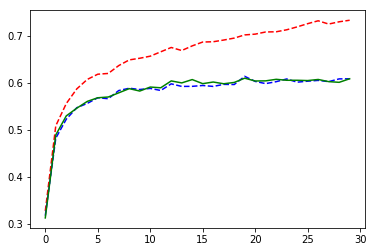

Accuracy of rate 0.001 = 0.6144230749744636, es = 0.6104700848587559


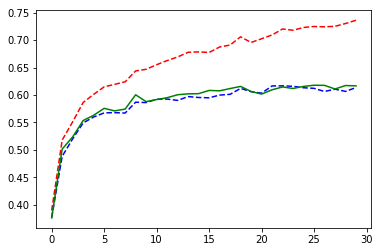

Accuracy of rate 0.005 = 0.6120726477768687, es = 0.6176816229636852


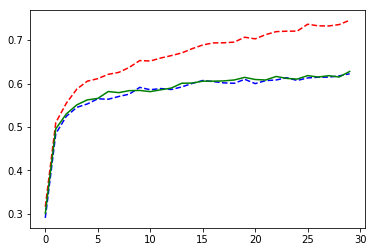

Accuracy of rate 0.008 = 0.6224358979071307, es = 0.6277243575733952


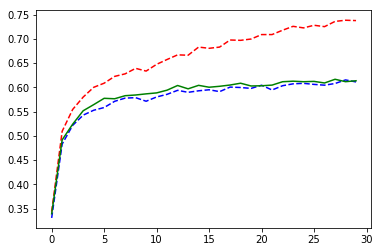

Accuracy of rate 0.01 = 0.6078525632619858, es = 0.6165598286777481


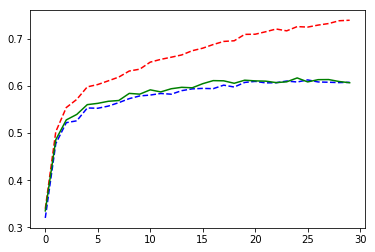

Accuracy of rate 0.05 = 0.6086538446255219, es = 0.6173076917600427


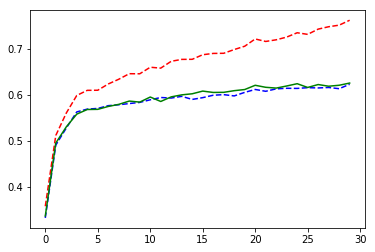

Accuracy of rate 0.1 = 0.6224893148892965, es = 0.6251602547163637


In [43]:
rms_rates = np.array([0.001,0.005,0.008,0.01,0.05,0.1])
for rate in rms_rates:
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.RMSPropOptimizer,rate)
        plt.figure
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}'.format(rate,va[np.argmax(es)],np.max(es)))

#### Based on the comparison, we see that $rate = 0.1$ is the best choice for RMS prop

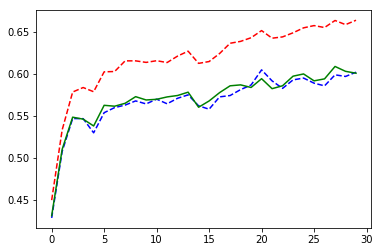

Accuracy of rate 0.001 = 0.5989850432572202, es = 0.6089743572549942


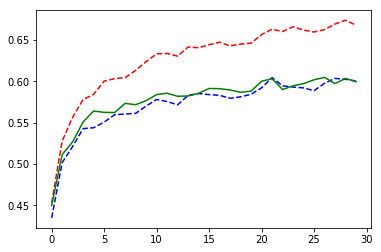

Accuracy of rate 0.005 = 0.5975961519994288, es = 0.6046474342926954


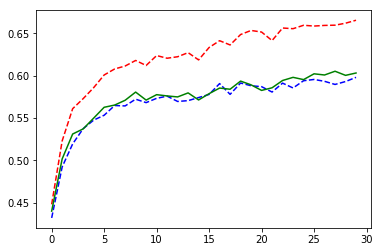

Accuracy of rate 0.008 = 0.5897970079356789, es = 0.6053952992981315


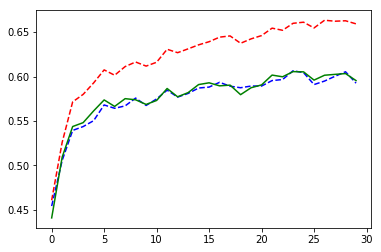

Accuracy of rate 0.01 = 0.6064636744622491, es = 0.6055021355931576


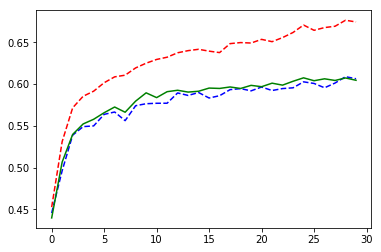

Accuracy of rate 0.05 = 0.6027777766187986, es = 0.6075854696779169


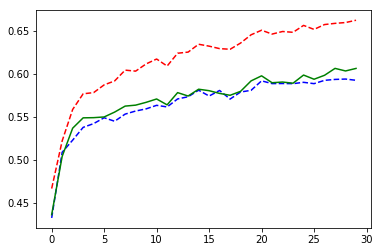

Accuracy of rate 0.1 = 0.5934829050149673, es = 0.6063034192873882


In [44]:
adam_rates = np.array([0.001,0.005,0.008,0.01,0.05,0.1])
for rate in adam_rates:
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26]) , tf.train.AdamOptimizer,rate)
        plt.figure
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy of rate {} = {}, es = {}'.format(rate,va[np.argmax(es)],np.max(es)))

#### Based on the comparison, we see that $rate = 0.01$ is the best choice for ADAM

### Now comparing the three algorithms with their best learning rates, we see that standard stochastic gradient descent with learning rate 0.05 has the best performance.

In [67]:
chosen_rate = 0.05;
chosen_opt = tf.train.GradientDescentOptimizer

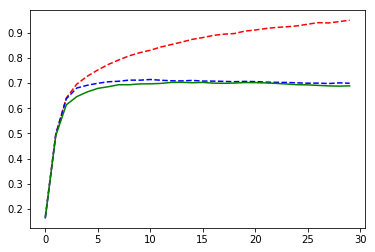

Accuracy with activation 'Sigmoid' = 0.7080662405643707, es = 0.7025641024112701


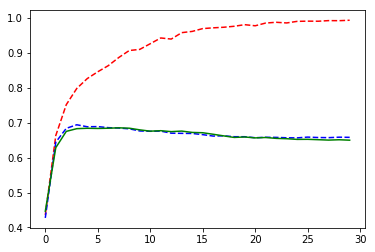

Accuracy with activation 'Tan_h' = 0.6849358967608875, es = 0.6856303400718249


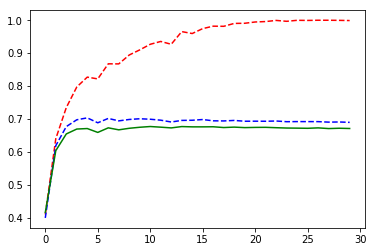

Accuracy with activation 'ReLU' = 0.6994658110488174, es = 0.6773504267390975


In [70]:
Algo = [tf.sigmoid, tf.tanh,tf.nn.relu]
names = ['Sigmoid', 'Tan_h', 'ReLU']

for i in range(len(Algo)):
    activation = Algo[i]
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26],activation) ,chosen_opt,chosen_rate)
        plt.figure
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy with activation \'{}\' = {}, es = {}'.format(names[i],va[np.argmax(es)],np.max(es)))

### The best activation function is this combination was Sigmoid

In [ ]:
for hidden_layers in range(3):
    with tf.Session() as sess:
        tr,va,es = try_comb(Train_Classifier(x,[20,26],activation) ,chosen_opt,chosen_rate)
        plt.figure
        plt.plot(tr,'r--')
        plt.plot(va,'b--')
        plt.plot(es,'g')
        plt.show()
        print('Accuracy with activation \'{}\' = {}, es = {}'.format(rate,va[np.argmax(es)],np.max(es)))

In [18]:
Logits

NameError: name 'Logits' is not defined

In [98]:
a = []
b = []
c = []

In [99]:
save_file = './modelTest1.ckpt'
Valid_acc_lists = {0:a, 1:b, 2:c}
Train_acc_lists = {0:a, 1:b, 2:c}
EarlyStopping_acc_lists = {0:a, 1:b, 2:c}
for j in range(len(Logits)):
    print ("------------------------------------------------------------------------",j)
    network(Logits[j])
    
    #np.array(train_acc_list)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train2)

        TempValidat_acc_list = []
        TempTrain_acc_list = []
        TempEarlyStopping_acc_list = []

        validat_acc_list = []
        train_acc_list = []
        earlyStoping_acc_list = []

        earlyStoppingMax = -1

        print("Training...")
        print()

        #logits = (Train_Classifier(x,[20,C], Algo[j]))
        #network(logits)
        for i in range(EPOCHS):
            """
            if len(validat_acc_list) > 1:
                if validat_acc_list[-1] < validat_acc_list[-2] - 1e-3:
                    print("#############STOP################")
                    break
            """ 
            X_train21, y_train21 = shuffle(X_train2,y_train2)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train21[offset:end], y_train21[offset:end]
                #logits = Logits[j]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                #print(logits)

            validation_accuracy = evaluate(X_validation, y_validation)
            training_accuracy = evaluate(X_train2, y_train2)
            earlyStoping_accuracy = evaluate(X_stop,y_stop)

            #if earlyStoppingMax < earlyStoping_accuracy:
                #earlyStoppingMax = earlyStoping_accuracy
                #print('Best so far = {} on iteration {}'.format(earlyStoppingMax,i))
                #saver.save(sess,save_file)
                #print(sess.run(tempw))

            validat_acc_list.append(validation_accuracy)
            train_acc_list.append(training_accuracy)
            earlyStoping_acc_list.append(earlyStoping_accuracy)
            
            """
            TempValidat_acc_list.append(validation_accuracy)
            TempTrain_acc_list.append(training_accuracy)
            TempEarlyStopping_acc_list.append(earlyStoping_accuracy)
            

            
            #if i%1 == 0:
            validat_acc_list.append(np.mean(TempValidat_acc_list))
            TempValidat_acc_list = []

            train_acc_list.append(np.mean(TempTrain_acc_list))
            TempTrain_acc_list = []           

            earlyStoping_acc_list.append(np.mean(TempEarlyStopping_acc_list))
            TempEarlyStopping_acc_list = []  
            """
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        Valid_acc_lists[j] = validat_acc_list
        Train_acc_lists[j] = train_acc_list
        EarlyStopping_acc_lists[j] = earlyStoping_acc_list
        




        #saver.save(sess, save_file)
        #print("Model saved")

------------------------------------------------------------------------ 0
Tensor("Add_13:0", shape=(?, 26), dtype=float32)
Initialized
Training...

EPOCH 1 ...
Validation Accuracy = 0.171
EPOCH 2 ...
Validation Accuracy = 0.326
EPOCH 3 ...
Validation Accuracy = 0.392
EPOCH 4 ...
Validation Accuracy = 0.456
EPOCH 5 ...
Validation Accuracy = 0.452
EPOCH 6 ...
Validation Accuracy = 0.507
EPOCH 7 ...
Validation Accuracy = 0.527
EPOCH 8 ...
Validation Accuracy = 0.525
EPOCH 9 ...
Validation Accuracy = 0.546
EPOCH 10 ...
Validation Accuracy = 0.573
EPOCH 11 ...
Validation Accuracy = 0.575
EPOCH 12 ...
Validation Accuracy = 0.569
EPOCH 13 ...
Validation Accuracy = 0.585
EPOCH 14 ...
Validation Accuracy = 0.574
EPOCH 15 ...
Validation Accuracy = 0.600
EPOCH 16 ...
Validation Accuracy = 0.604
EPOCH 17 ...
Validation Accuracy = 0.609
EPOCH 18 ...
Validation Accuracy = 0.631
EPOCH 19 ...
Validation Accuracy = 0.612
EPOCH 20 ...
Validation Accuracy = 0.635
EPOCH 21 ...
Validation Accuracy = 0.627

EPOCH 95 ...
Validation Accuracy = 0.696
EPOCH 96 ...
Validation Accuracy = 0.677
EPOCH 97 ...
Validation Accuracy = 0.698
EPOCH 98 ...
Validation Accuracy = 0.694
EPOCH 99 ...
Validation Accuracy = 0.696
EPOCH 100 ...
Validation Accuracy = 0.700
------------------------------------------------------------------------ 2
Tensor("Add_17:0", shape=(?, 26), dtype=float32)
Initialized
Training...

EPOCH 1 ...
Validation Accuracy = 0.231
EPOCH 2 ...
Validation Accuracy = 0.327
EPOCH 3 ...
Validation Accuracy = 0.415
EPOCH 4 ...
Validation Accuracy = 0.454
EPOCH 5 ...
Validation Accuracy = 0.467
EPOCH 6 ...
Validation Accuracy = 0.517
EPOCH 7 ...
Validation Accuracy = 0.513
EPOCH 8 ...
Validation Accuracy = 0.546
EPOCH 9 ...
Validation Accuracy = 0.544
EPOCH 10 ...
Validation Accuracy = 0.576
EPOCH 11 ...
Validation Accuracy = 0.575
EPOCH 12 ...
Validation Accuracy = 0.589
EPOCH 13 ...
Validation Accuracy = 0.579
EPOCH 14 ...
Validation Accuracy = 0.592
EPOCH 15 ...
Validation Accuracy = 0.61

In [100]:
a = np.array(train_acc_list)
b = np.array(validat_acc_list)
c = np.array(earlyStoping_acc_list)

abc = {0: a, 1:b, 2:c}

In [101]:
abc[0] = np.array(train_acc_list)

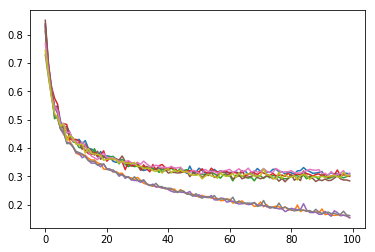

In [102]:
for i in range (len(Valid_acc_lists)):
    plt.plot(1- np.array(Valid_acc_lists[i]))
    plt.plot(1- np.array(Train_acc_lists[i]))
    plt.plot(1- np.array(EarlyStopping_acc_lists[i]))
    
plt.show()

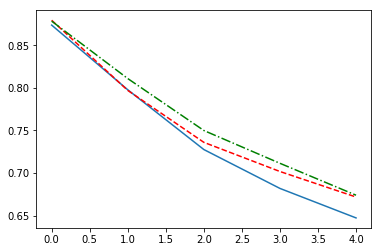

In [29]:
plt.plot(1-np.array(train_acc_list))
plt.plot(1-np.array(validat_acc_list),'r--')
plt.plot(1-np.array(earlyStoping_acc_list),'g-.')
plt.show()

In [ ]:
plt.plot(validat_acc_list)
plt.show()

In [ ]:
plt.plot(validat_acc_list)
plt.show()

In [ ]:
plt.plot(earlyStoping_acc_list)
plt.show()

In [ ]:
plt.plot(earlyStoping_acc_list)
plt.show()

In [ ]:

#tf.reset_default_graph()
n_hidden_layer1 =20 

n_input1 = n_TrainFeatures #300
n_classes = n_TrainClasses #26
# n_input1, n_hidden_layer1 n_classes

tf.reset_default_graph()

layer1_W = tf.Variable(tf.truncated_normal([n_input1, n_hidden_layer1]),name='weights_1')
layer1_b = tf.Variable(tf.zeros(n_hidden_layer1),name='bias_1')


# Layer 2: Output layer
layer2_W = tf.Variable(tf.truncated_normal([n_hidden_layer1, n_classes]),name='weights_2')
layer2_b = tf.Variable(tf.zeros(n_classes),name='bias_2')

saver = tf.train.Saver()
with tf.Session() as sess:

    saver.restore(sess, save_file)
    #evaluate(X_stop,y_stop);
    temp = (sess.run(layer1_W))
print('Loaded Weights successfully.')

In [ ]:
import tensorflow as tf

tf.reset_default_graph()

save_file = './Test2.ckpt'

# Two Tensor Variables: weights and bias

bias = tf.Variable(tf.truncated_normal([3]))
weights = tf.Variable(tf.truncated_normal([2, 3]))

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Save Weights: {}'.format(weights))
print('Save Bias: {}'.format(bias))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, save_file)

# Remove the previous weights and bias
tf.reset_default_graph()

# Two Variables: weights and bias
bias = tf.Variable(tf.truncated_normal([3]))
weights = tf.Variable(tf.truncated_normal([2, 3]))

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Load Weights: {}'.format(weights))
print('Load Bias: {}'.format(bias))

with tf.Session() as sess:
    # Load the weights and bias - No Error
    saver.restore(sess, save_file)

print('Loaded Weights and Bias successfully.')

In [ ]:
import tensorflow as tf

tf.reset_default_graph()

save_file = './Test.ckpt'

# Two Tensor Variables: weights and bias
weights = tf.Variable(tf.truncated_normal([2, 3]), name='weights_0')
bias = tf.Variable(tf.truncated_normal([3]), name='bias_0')

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Save Weights: {}'.format(weights.name))
print('Save Bias: {}'.format(bias.name))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, save_file)

# Remove the previous weights and bias
tf.reset_default_graph()

# Two Variables: weights and bias
bias = tf.Variable(tf.truncated_normal([3]), name='bias_0')
weights = tf.Variable(tf.truncated_normal([2, 3]) ,name='weights_0')

saver = tf.train.Saver()

# Print the name of Weights and Bias
print('Load Weights: {}'.format(weights.name))
print('Load Bias: {}'.format(bias.name))

with tf.Session() as sess:
    # Load the weights and bias - No Error
    saver.restore(sess, save_file)

print('Loaded Weights and Bias successfully.')